# Head

In [1]:
import pandas as pd

test = pd.read_csv('/home/lyuzhuoqi/projects/TLDR/data/paper_html_10.1038/abs_annotation/test.tsv', sep='\t')
deepseek_v3 = pd.read_csv('/home/lyuzhuoqi/projects/TLDR/data/paper_html_10.1038/abs_annotation/generated_annotations/deepseek_v3.txt', 
                          sep='\t', header=None, names=['deepseek_v3'])
gemma3 = pd.read_csv('/home/lyuzhuoqi/projects/TLDR/data/paper_html_10.1038/abs_annotation/generated_annotations/gemma3_TLDR.txt',
                          sep='\t', header=None, names=['gemma3'])
llama4 = pd.read_csv('/home/lyuzhuoqi/projects/TLDR/data/paper_html_10.1038/abs_annotation/generated_annotations/llama4_TLDR.txt',
                          sep='\t', header=None, names=['llama4'])
qwq = pd.read_csv('/home/lyuzhuoqi/projects/TLDR/data/paper_html_10.1038/abs_annotation/generated_annotations/qwq_TLDR.txt',
                          sep='\t', header=None, names=['qwq'])
df = test.join([deepseek_v3, gemma3, llama4, qwq])

for index in pd.read_csv("/home/lyuzhuoqi/projects/TLDR/description/invalid_entry_in_test.txt", sep='\t', header=None).values.flatten().tolist():
    df = df.drop(index-2)  # Adjusting for zero-based index
df

,abs_doi,paper_id,abstract,annotation,deepseek_v3,gemma3,llama4,qwq
0,10.1073/pnas.91.7.2757,107202074,The origin and taxonomic status of domesticate...,A demonstration that cattle have been domestic...,This study provides genetic evidence for two i...,Reference 16 provides a molecular phylogeny of...,This study proposes that zebu and taurine catt...,This study uses mitochondrial DNA analysis to ...
1,10.1093/genetics/154.4.1785,83366887,Abstract The domestic pig originates from the ...,Evidence is presented for independent domestic...,This study provides genetic evidence for indep...,This study demonstrates independent domesticat...,This study reports the origin of European and ...,This study uses mitochondrial and nuclear DNA ...
2,10.1073/pnas.96.16.9252,122095374,We previously mapped a quantitative trait locu...,This paper shows how the identity-by-descent a...,This study reports the fine-mapping of a QTL f...,Reference 53 reports fine-mapping of a QTL for...,The QTL was fine-mapped to a 5 cM region on BT...,This study uses high-density marker genotyping...
3,10.1101/gr.10.2.220,100831446,A genome-wide linkage disequilibrium (LD) map ...,The pattern of linkage disequilibrium (LD) acr...,This study provides the first genome-wide LD m...,This study documents an unusually strong and l...,The authors provide evidence that linkage dise...,This study generates a genome-wide linkage dis...
4,10.1126/science.8134840,17452622,The European wild boar was crossed with the do...,The first paper to show the use of divergent i...,This study identifies a major QTL on chromosom...,This study identifies a major QTL on pig chrom...,This study reports a major QTL on SSC4 for fat...,This study identifies a major quantitative tra...
...,...,...,...,...,...,...,...,...
35631,10.2337/db08-1168,4860455,OBJECTIVE—Regulatory T-cells (Tregs) have cata...,This article describes the good manufacturing ...,This study demonstrates that CD4+CD127lo/−CD25...,This study provides a method for isolation and...,This study demonstrates that Tregs can be expa...,This study evaluates methods for isolating and...
35632,10.1126/science.aar3246,4860145,Engineering cytokine-receptor pairs Interleuki...,This study reports the generation of an orthog...,This study reports the engineering of orthogon...,This study describes an engineered IL-2/IL-2R ...,This study presents an engineered IL-2 partial...,This study engineers synthetic IL-2–receptor p...
35633,10.1126/science.aad2791,62290395,T cells target peptide combos One of the endur...,This article shows that some diabetogenic T ce...,This study identifies hybrid insulin peptides ...,This study reports the identification of hybri...,This study highlights the potential importance...,This study identifies hybrid peptides—covalent...
35634,10.1073/pnas.1902566116,82979762,Polymorphic HLAs form the primary immune barri...,This article describes the development of gene...,This study demonstrates a multiplex genome-edi...,This work reports on a cell engineering strate...,This study identifies a strategy for broad imm...,This study describes a dual strategy to engine...


# Overlap-based

In [16]:
def evaluate_metrics(df, pred_col='prediction', ref_col='reference'):
    references = df[ref_col].tolist()
    predictions = df[pred_col].tolist()

    bleu = load_metric("bleu")
    bleu_result = bleu.compute(predictions=[pred.split() for pred in predictions],
                              references=[[ref.split()] for ref in references])

    meteor = load_metric("meteor")
    meteor_result = meteor.compute(predictions=predictions, references=references)

    rouge = load_metric("rouge")
    rouge_result = rouge.compute(predictions=predictions, references=references, rouge_types=["rouge1", "rouge2", "rouge3", "rougeL"])

    # 只返回需要的分数，便于后续统计平均
    rouge_f = {}
    for rouge_type in ["rouge1", "rouge2", "rouge3", "rougeL"]:
        score = rouge_result[rouge_type]
        if hasattr(score, "mid"):
            f_val = score.mid.fmeasure
        else:
            f_val = score.fmeasure
        rouge_f[rouge_type] = f_val

    return {
        'bleu': bleu_result["bleu"],
        'meteor': meteor_result["meteor"],
        'rouge': rouge_f
    }

In [7]:
evaluate_metrics(df, pred_col='deepseek_v3', ref_col='annotation')

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/lyuzhuoqi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/lyuzhuoqi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/lyuzhuoqi/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


BLEU: 0.0173
METEOR: 0.2563
ROUGE (F):
  ROUGE1: 0.2547
  ROUGE2: 0.0577
  ROUGE3: 0.0167
  ROUGEL: 0.1854


({'bleu': 0.01731665206725385,
  'precisions': [0.163043219550204,
   0.030028989221134905,
   0.007557837650724052,
   0.0024300471979609084],
  'brevity_penalty': 1.0,
  'length_ratio': 1.8919156560545483,
  'translation_length': 1596546,
  'reference_length': 843878},
 {'meteor': 0.2563322425013617},
 {'rouge1': AggregateScore(low=Score(precision=0.2024238317867394, recall=0.39364699810305115, fmeasure=0.25376668077147685), mid=Score(precision=0.2033713322171768, recall=0.39506247541355566, fmeasure=0.25469668149225966), high=Score(precision=0.20428930952762953, recall=0.39652337629291523, fmeasure=0.2556147081796674)),
  'rouge2': AggregateScore(low=Score(precision=0.04534077226299694, recall=0.09054274290339476, fmeasure=0.05710614074772894), mid=Score(precision=0.04579359959140271, recall=0.09139755949948664, fmeasure=0.05766748366279875), high=Score(precision=0.046255622140344, recall=0.09235367417149867, fmeasure=0.05822763934891075)),
  'rouge3': AggregateScore(low=Score(preci

In [8]:
evaluate_metrics(df, pred_col='gemma3', ref_col='annotation')

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/lyuzhuoqi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/lyuzhuoqi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/lyuzhuoqi/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


BLEU: 0.0226
METEOR: 0.2256
ROUGE (F):
  ROUGE1: 0.2627
  ROUGE2: 0.0585
  ROUGE3: 0.0177
  ROUGEL: 0.2006


({'bleu': 0.022627707969720814,
  'precisions': [0.2050606467056805,
   0.03701589241801375,
   0.010069484264488214,
   0.0034299239131888263],
  'brevity_penalty': 1.0,
  'length_ratio': 1.1900523535392558,
  'translation_length': 1004259,
  'reference_length': 843878},
 {'meteor': 0.2255549493536052},
 {'rouge1': AggregateScore(low=Score(precision=0.24667395041709736, recall=0.3098618492452475, fmeasure=0.2616524926881744), mid=Score(precision=0.24789105983518217, recall=0.3112095940256782, fmeasure=0.262699954460377), high=Score(precision=0.24903928862189176, recall=0.3125092364042356, fmeasure=0.2637429711462288)),
  'rouge2': AggregateScore(low=Score(precision=0.054510875213243465, recall=0.06938194972044685, fmeasure=0.05789166460304463), mid=Score(precision=0.05509706501962529, recall=0.0701792177068239, fmeasure=0.058532396330753134), high=Score(precision=0.0557708147051159, recall=0.07098718272994581, fmeasure=0.05921374069391427)),
  'rouge3': AggregateScore(low=Score(precis

In [9]:
evaluate_metrics(df, pred_col='llama4', ref_col='annotation')

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/lyuzhuoqi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/lyuzhuoqi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/lyuzhuoqi/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


BLEU: 0.0081
METEOR: 0.2080
ROUGE (F):
  ROUGE1: 0.2417
  ROUGE2: 0.0509
  ROUGE3: 0.0141
  ROUGEL: 0.1839


({'bleu': 0.008064265499864233,
  'precisions': [0.07812022503253915,
   0.013836583152031078,
   0.003454858841733114,
   0.0011324958513672383],
  'brevity_penalty': 1.0,
  'length_ratio': 3.2029487674758674,
  'translation_length': 2702898,
  'reference_length': 843878},
 {'meteor': 0.20799707466094394},
 {'rouge1': AggregateScore(low=Score(precision=0.23043558832132777, recall=0.30532259281025875, fmeasure=0.24075758630296284), mid=Score(precision=0.23158367199480978, recall=0.3068414106027987, fmeasure=0.24170628018329116), high=Score(precision=0.23280796368105358, recall=0.30836635039441174, fmeasure=0.2426807702272981)),
  'rouge2': AggregateScore(low=Score(precision=0.04778901304397373, recall=0.0658686495987634, fmeasure=0.05020570156030343), mid=Score(precision=0.04841910291466078, recall=0.06675460455888081, fmeasure=0.05085622881968121), high=Score(precision=0.04903997594375016, recall=0.06762893158947768, fmeasure=0.05145615162545445)),
  'rouge3': AggregateScore(low=Score

In [10]:
evaluate_metrics(df, pred_col='qwq', ref_col='annotation')

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/lyuzhuoqi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/lyuzhuoqi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/lyuzhuoqi/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


BLEU: 0.0103
METEOR: 0.2451
ROUGE (F):
  ROUGE1: 0.2066
  ROUGE2: 0.0436
  ROUGE3: 0.0117
  ROUGEL: 0.1446


({'bleu': 0.010308416862885706,
  'precisions': [0.1137471331346138,
   0.01893531714138721,
   0.004273766663161797,
   0.001226716030995881],
  'brevity_penalty': 1.0,
  'length_ratio': 3.172425397984069,
  'translation_length': 2677140,
  'reference_length': 843878},
 {'meteor': 0.2450748916074611},
 {'rouge1': AggregateScore(low=Score(precision=0.14233822495664, recall=0.45013448557706504, fmeasure=0.20576069563827085), mid=Score(precision=0.14307577082535727, recall=0.4515823296692879, fmeasure=0.20658541647972872), high=Score(precision=0.1437717050448007, recall=0.4529361549345725, fmeasure=0.20739782842750498)),
  'rouge2': AggregateScore(low=Score(precision=0.029736386619152514, recall=0.09699650326042873, fmeasure=0.04320942686294227), mid=Score(precision=0.030042064025618286, recall=0.09784970861332676, fmeasure=0.04360443999939843), high=Score(precision=0.030364459753357078, recall=0.09884157816542812, fmeasure=0.0440353990683343)),
  'rouge3': AggregateScore(low=Score(preci

## Multi-annotated abstracts as a human-evaluation baseline

In [2]:
full = pd.read_csv('/home/lyuzhuoqi/projects/TLDR/data/paper_html_10.1038/abs_annotation/abs_annotation.tsv', sep='\t')
print('# of papers: ', full['paper_id'].nunique())

multi_annotated = full[full['paper_id'].isin(full['paper_id'].value_counts()[full['paper_id'].value_counts() > 1].index)]
display(multi_annotated)
print(multi_annotated['paper_id'].unique().shape[0], 'papers are annotated by multiple annotators')

# of papers:  29356


,abs_doi,paper_id,abstract,annotation
0,10.1073/pnas.91.7.2757,107202074,The origin and taxonomic status of domesticate...,A demonstration that cattle have been domestic...
1,10.1093/genetics/154.4.1785,83366887,Abstract The domestic pig originates from the ...,Evidence is presented for independent domestic...
7,10.1083/jcb.153.2.397,58551536,The correct positioning of the nucleus is ofte...,Using live imaging and computer simulation the...
8,10.1101/gad.14.6.690,131922988,E2F is a family of transcription factors that ...,"Disruption of mouse E2f3 , but not E2f1 , redu..."
10,10.1101/gad.859201,18000382,Telomere shortening is the mechanism underlyin...,Growing primary human keratinocytes and mammar...
...,...,...,...,...
35633,10.1126/scitranslmed.aad4134,103721459,Autologous regulatory T cells can be expanded ...,First clinical trial demonstrating up to 1 yea...
35634,10.1084/jem.20040139,83080620,The low number of CD4+ CD25+ regulatory T cell...,Seminal study showing that antigen-specific T ...
35637,10.1126/science.aar3246,4860145,Engineering cytokine-receptor pairs Interleuki...,This study reports the generation of an orthog...
35638,10.1126/science.aad2791,62290395,T cells target peptide combos One of the endur...,This article shows that some diabetogenic T ce...


4019 papers are annotated by multiple annotators


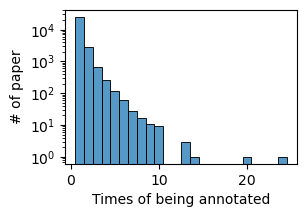

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

paper_id_counts = full['paper_id'].value_counts()
plt.figure(figsize=(3, 2))
sns.histplot(paper_id_counts, bins=30, stat='count', discrete=True)
plt.yscale('log')
plt.xlabel('Times of being annotated')
plt.ylabel('# of paper')
plt.show()

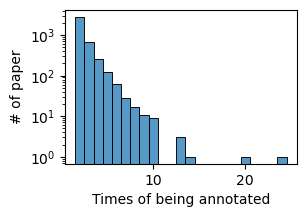

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

paper_id_counts = multi_annotated['paper_id'].value_counts()
plt.figure(figsize=(3, 2))
sns.histplot(paper_id_counts, bins=30, stat='count', discrete=True)
plt.yscale('log')
plt.xlabel('Times of being annotated')
plt.ylabel('# of paper')
plt.show()

In [ ]:
import random
from tqdm import tqdm

all_scores = []
n_sample = 10  # 抽样次数

for _ in tqdm(range(n_sample)):
    grouped = multi_annotated.groupby('paper_id')
    results = []
    for paper_id, group in grouped:
        annotations = group['annotation'].tolist()
        if len(annotations) < 2:
            continue
        ref = random.choice(annotations)
        preds = [a for a in annotations if a != ref]
        for pred in preds:
            results.append({'paper_id': paper_id, 'reference': ref, 'prediction': pred})

    eval_df = pd.DataFrame(results)
    scores = evaluate_metrics(eval_df, pred_col='prediction', ref_col='reference')
    all_scores.append(scores)

# 计算平均分
bleu_avg = sum(s['bleu'] for s in all_scores) / n_sample
meteor_avg = sum(s['meteor'] for s in all_scores) / n_sample
rouge_avg = {}
for rouge_type in ["rouge1", "rouge2", "rouge3", "rougeL"]:
    rouge_avg[rouge_type] = sum(s['rouge'][rouge_type] for s in all_scores) / n_sample

print("=== 10次抽样平均 ===")
print("BLEU: {:.4f}".format(bleu_avg))
print("METEOR: {:.4f}".format(meteor_avg))
print("ROUGE (F):")
for rouge_type in ["rouge1", "rouge2", "rouge3", "rougeL"]:
    print("  {}: {:.4f}".format(rouge_type.upper(), rouge_avg[rouge_type]))

  0%|                                                                                    | 0/10 [00:00<?, ?it/s][nltk_data] Downloading package wordnet to
[nltk_data]     /home/lyuzhuoqi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/lyuzhuoqi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/lyuzhuoqi/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 10%|███████▌                                                                    | 1/10 [00:12<01:51, 12.40s/it][nltk_data] Downloading package wordnet to
[nltk_data]     /home/lyuzhuoqi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/lyuzhuoqi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/lyuzhuoqi/nltk_data...
[nltk_data]   Package o

=== 10次抽样平均 ===
BLEU: 0.0389
METEOR: 0.2156
ROUGE (F):
  ROUGE1: 0.2738
  ROUGE2: 0.0676
  ROUGE3: 0.0243
  ROUGEL: 0.2162


# Simlarity-based

## BERTScore

In [ ]:
from bert_score import score

def evaluate_bertscore(df, pred_col='prediction', ref_col='reference'):
    preds = df[pred_col].tolist()
    refs = df[ref_col].tolist()

    P, R, F1 = score(preds, refs, lang='en', verbose=True)  # 如果是中文，改为 lang='zh'
    print(f"BERTScore F1: {F1.mean().item():.4f}")
    return {
        "BERTScore_P": P.mean().item(),
        "BERTScore_R": R.mean().item(),
        "BERTScore_F1": F1.mean().item()
    }


In [24]:
evaluate_bertscore(df, pred_col='deepseek_v3', ref_col='annotation')

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1111 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/557 [00:00<?, ?it/s]

done in 379.09 seconds, 93.96 sentences/sec
BERTScore F1: 0.8752


{'BERTScore_P': 0.859603226184845,
 'BERTScore_R': 0.8917859792709351,
 'BERTScore_F1': 0.8752175569534302}

In [27]:
evaluate_bertscore(df, pred_col='gemma3', ref_col='annotation')

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1113 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/557 [00:00<?, ?it/s]

done in 283.89 seconds, 125.48 sentences/sec
BERTScore F1: 0.8802


{'BERTScore_P': 0.8740829229354858,
 'BERTScore_R': 0.886883556842804,
 'BERTScore_F1': 0.8802496194839478}

In [28]:
evaluate_bertscore(df, pred_col='llama4', ref_col='annotation')

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1113 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/557 [00:00<?, ?it/s]

done in 316.19 seconds, 112.66 sentences/sec
BERTScore F1: 0.8771


{'BERTScore_P': 0.8746355772018433,
 'BERTScore_R': 0.8801242113113403,
 'BERTScore_F1': 0.8771476745605469}

In [29]:
evaluate_bertscore(df, pred_col='qwq', ref_col='annotation')

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1113 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/557 [00:00<?, ?it/s]

done in 608.11 seconds, 58.58 sentences/sec
BERTScore F1: 0.8607


{'BERTScore_P': 0.83527010679245,
 'BERTScore_R': 0.8880637288093567,
 'BERTScore_F1': 0.8606795072555542}

## Multi-annotated abstracts as a human-evaluation baseline

In [30]:
import random
from tqdm import tqdm

all_scores = []
n_sample = 10  # 抽样次数

for _ in tqdm(range(n_sample)):
    grouped = multi_annotated.groupby('paper_id')
    results = []
    for paper_id, group in grouped:
        annotations = group['annotation'].tolist()
        if len(annotations) < 2:
            continue
        ref = random.choice(annotations)
        preds = [a for a in annotations if a != ref]
        for pred in preds:
            results.append({'paper_id': paper_id, 'reference': ref, 'prediction': pred})

    eval_df = pd.DataFrame(results)
    scores = evaluate_bertscore(eval_df, pred_col='prediction', ref_col='reference')
    all_scores.append(scores)

# 计算平均分
bertscore_avg = sum(s['BERTScore_F1'] for s in all_scores) / n_sample

print("=== 10次抽样平均 ===")
print("BERTScore: {:.4f}".format(bertscore_avg))

  0%|                                                                                    | 0/10 [00:00<?, ?it/s]Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/161 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/99 [00:00<?, ?it/s]

 10%|███████▌                                                                    | 1/10 [00:38<05:50, 39.00s/it]

done in 37.19 seconds, 168.93 sentences/sec
BERTScore F1: 0.8811


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/161 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/99 [00:00<?, ?it/s]

 20%|███████████████▏                                                            | 2/10 [01:16<05:04, 38.12s/it]

done in 37.41 seconds, 167.90 sentences/sec
BERTScore F1: 0.8812


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/161 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/99 [00:00<?, ?it/s]

 30%|██████████████████████▊                                                     | 3/10 [01:55<04:28, 38.29s/it]

done in 37.74 seconds, 166.45 sentences/sec
BERTScore F1: 0.8812


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/161 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/99 [00:00<?, ?it/s]

 40%|██████████████████████████████▍                                             | 4/10 [02:33<03:50, 38.42s/it]

done in 37.65 seconds, 166.86 sentences/sec
BERTScore F1: 0.8813


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/161 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/99 [00:00<?, ?it/s]

 50%|██████████████████████████████████████                                      | 5/10 [03:12<03:12, 38.51s/it]

done in 37.83 seconds, 166.05 sentences/sec
BERTScore F1: 0.8813


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/161 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/99 [00:00<?, ?it/s]

 60%|█████████████████████████████████████████████▌                              | 6/10 [03:50<02:33, 38.31s/it]

done in 37.71 seconds, 166.58 sentences/sec
BERTScore F1: 0.8811


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/161 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/99 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████▏                      | 7/10 [04:28<01:55, 38.43s/it]

done in 37.82 seconds, 166.09 sentences/sec
BERTScore F1: 0.8813


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/161 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/99 [00:00<?, ?it/s]

 80%|████████████████████████████████████████████████████████████▊               | 8/10 [05:07<01:16, 38.48s/it]

done in 37.64 seconds, 166.84 sentences/sec
BERTScore F1: 0.8814


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/161 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/99 [00:00<?, ?it/s]

 90%|████████████████████████████████████████████████████████████████████▍       | 9/10 [05:45<00:38, 38.45s/it]

done in 37.64 seconds, 166.86 sentences/sec
BERTScore F1: 0.8811


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/161 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/99 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████| 10/10 [06:24<00:00, 38.49s/it]

done in 37.97 seconds, 165.43 sentences/sec
BERTScore F1: 0.8813
=== 10次抽样平均 ===
BERTScore: 0.8812


## MoverScore

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys
sys.path.append('/home/lyuzhuoqi/projects/TLDR/evaluation/ref_based')

from moverscore_v2 import get_idf_dict, word_mover_score 
from nltk.corpus import stopwords

import numpy as np

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

def evaluate_moverscore(df, pred_col='prediction', ref_col='reference'):
    preds = df[pred_col].tolist()
    refs = df[ref_col].tolist()

    idf_dict_hyp = get_idf_dict(preds)
    idf_dict_ref = get_idf_dict(refs)

    scores = word_mover_score(refs, preds, idf_dict_ref, idf_dict_hyp, stop_words=stopwords.words('english'))

    return np.mean(scores)


/home/lyuzhuoqi/miniconda3/envs/p2v/lib/python3.11/site-packages/pyemd/__init__.py:74: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from .emd import emd, emd_with_flow, emd_samples


In [7]:
evaluate_moverscore(df, pred_col='deepseek_v3', ref_col='annotation')

Calculating WMS: 100%|████████████████████████████████████████████████████████| 140/140 [26:29<00:00, 11.35s/it]


0.5605247859286613

In [5]:
evaluate_moverscore(df, pred_col='gemma3', ref_col='annotation')

Token indices sequence length is longer than the specified maximum sequence length for this model (944 > 512). Running this sequence through the model will result in indexing errors
Calculating WMS: 100%|████████████████████████████████████████████████████████| 279/279 [04:22<00:00,  1.06it/s]


0.5647836527205226

In [6]:
evaluate_moverscore(df, pred_col='llama4', ref_col='annotation')

Calculating WMS: 100%|████████████████████████████████████████████████████████| 279/279 [59:27<00:00, 12.79s/it]


0.5584464708240221

In [7]:
evaluate_moverscore(df, pred_col='qwq', ref_col='annotation')

Calculating WMS: 100%|████████████████████████████████████████████████████████| 279/279 [55:58<00:00, 12.04s/it]


0.5462896681747191

## Multi-annotated abstracts as a human-evaluation baseline

In [10]:
import random
from tqdm import tqdm

all_scores = []
n_sample = 10  # 抽样次数

for _ in tqdm(range(n_sample)):
    grouped = multi_annotated.groupby('paper_id')
    results = []
    for paper_id, group in grouped:
        annotations = group['annotation'].tolist()
        if len(annotations) < 2:
            continue
        ref = random.choice(annotations)
        preds = [a for a in annotations if a != ref]
        for pred in preds:
            results.append({'paper_id': paper_id, 'reference': ref, 'prediction': pred})

    eval_df = pd.DataFrame(results)
    score = evaluate_moverscore(eval_df, pred_col='prediction', ref_col='reference')
    all_scores.append(score)

# 计算平均分
moverscore_avg = np.mean(all_scores)

print("=== 10次抽样平均 ===")
print("MoverScore: {:.4f}".format(moverscore_avg))

100%|███████████████████████████████████████████████████████████████████████████| 10/10 [07:18<00:00, 43.86s/it]

=== 10次抽样平均 ===
MoverScore: 0.5644


# QA-based